In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fv = pd.read_csv('../../Data/feature_vector.csv')
fv.head()

,index,sequence_label,source,generator,chisqr_p,chisqr_X2.X-squared,chisqr_df.df,ks_p,ks_D.D,freq_p,...,gap_p,gap_X2.X-squared,gap_df.df,serial_autocorrelation,perm_observed_stat,perm_p,entropy_val,fft_dominant_frequency,fft_dominant_period,fft_max_magnitude
0,1,randoms-1,QRNG,IBM Qiskit (Single-Qubit),0.000005,41.24,9,4.015142e-05,0.104000,0.000005,...,5.973983e-108,634.069388,40,0.062339,4.854,1.0,3.271215,0.096,10.416667,175.438884
1,2,randoms-10,QRNG,IBM Qiskit (Single-Qubit),0.000010,39.24,9,1.988713e-04,0.096000,0.000010,...,6.612279e-138,789.232653,43,-0.042322,5.050,1.0,3.272462,0.338,2.958580,181.936266
2,3,randoms-100,PRNG,Linear Congruential Generator (LCG),0.989425,2.12,9,9.079986e-05,0.100000,0.989425,...,3.376871e-161,825.600000,21,-0.065012,5.592,1.0,3.318868,0.500,2.000000,196.000000
3,4,randoms-101,PRNG,XORShift,0.337688,10.16,9,4.200665e-07,0.124000,0.337688,...,4.409093e-129,746.310204,43,0.059702,5.282,1.0,3.307208,0.054,18.518519,162.277093
4,5,randoms-102,PRNG,XORShift,0.040108,17.60,9,1.240019e-06,0.119556,0.040108,...,4.211260e-112,657.371429,41,0.013732,5.748,1.0,3.297016,0.338,2.958580,187.311277


In [3]:
features = {
    'uniformity': ['chisqr_p', 'ks_p', 'freq_p', 'eqdist_diff'],
    'patterns': ['gap_p', 'serial_autocorrelation'],
    'periodicity': ['entropy_val', 'fft_max_magnitude']
}

In [4]:
def normalize_feature(series, invert=False):
    min_val, max_val = series.min(), series.max()
    if min_val == max_val:
        return np.zeros(len(series)) if invert else np.ones(len(series))
    normalized = (series - min_val) / (max_val - min_val)
    return normalized if invert else 1 - normalized

In [5]:
sub_scores = {}
for category, feats in features.items():
    category_scores = []
    for feat in feats:
        if feat in ['eqdist_diff', 'serial_autocorrelation', 'fft_max_magnitude']:
            normalized = normalize_feature(fv[feat], invert=True)
        else:
            normalized = normalize_feature(fv[feat], invert=False)
        category_scores.append(normalized)
    sub_scores[category] = np.mean(category_scores, axis=0)

In [6]:
randomness_score = np.mean([sub_scores['uniformity'], sub_scores['patterns'], sub_scores['periodicity']], axis=0)

In [7]:
fv_scored = fv.copy()

fv_scored['uniformity_score'] = sub_scores['uniformity']
fv_scored['patterns_score'] = sub_scores['patterns']
fv_scored['periodicity_score'] = sub_scores['periodicity']
fv_scored['randomness_score'] = randomness_score

fv_scored.to_csv('feature_vector_scored.csv', index=False)

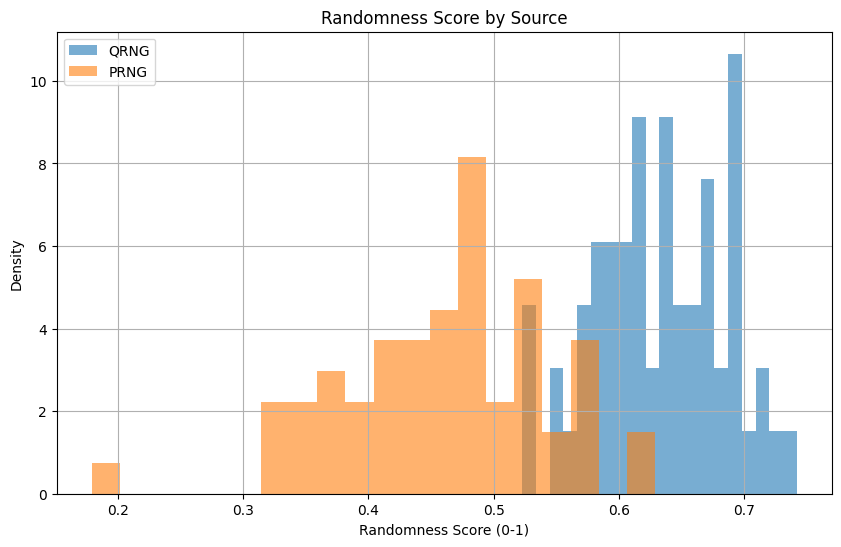

        count      mean       std       min       25%       50%       75%  \
source                                                                      
PRNG     60.0  0.462480  0.082749  0.179647  0.411492  0.472298  0.526405   
QRNG     60.0  0.632057  0.052863  0.522707  0.594113  0.632798  0.672973   

             max  
source            
PRNG    0.628687  
QRNG    0.741631  


In [8]:
plt.figure(figsize=(10, 6))
for source in fv_scored['source'].unique():
    subset = fv_scored[fv_scored['source'] == source]
    plt.hist(subset['randomness_score'], bins=20, alpha=0.6, label=source, density=True)
plt.title("Randomness Score by Source")
plt.xlabel("Randomness Score (0-1)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

print(fv_scored.groupby('source')['randomness_score'].describe())

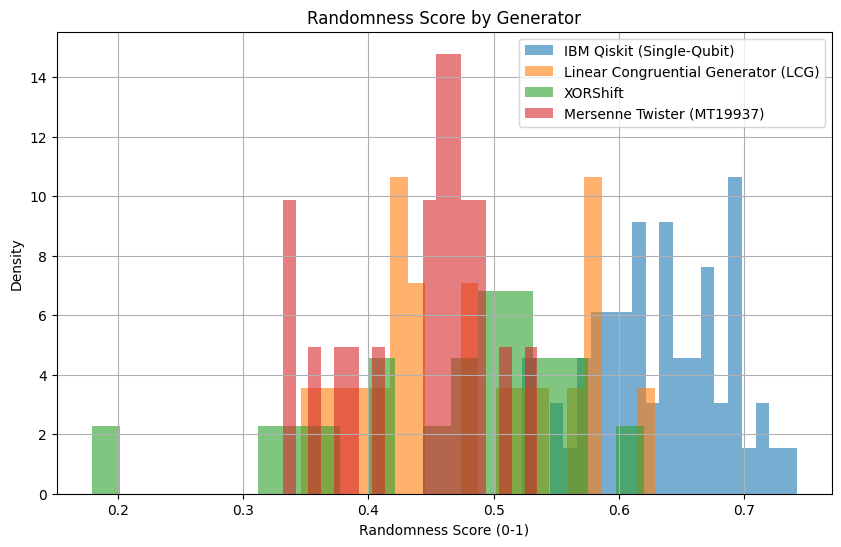

                                     count      mean       std       min  \
generator                                                                  
IBM Qiskit (Single-Qubit)             60.0  0.632057  0.052863  0.522707   
Linear Congruential Generator (LCG)   20.0  0.476584  0.082144  0.346618   
Mersenne Twister (MT19937)            20.0  0.443417  0.058181  0.331876   
XORShift                              20.0  0.467439  0.102531  0.179647   

                                          25%       50%       75%       max  
generator                                                                    
IBM Qiskit (Single-Qubit)            0.594113  0.632798  0.672973  0.741631  
Linear Congruential Generator (LCG)  0.420996  0.462848  0.538923  0.628687  
Mersenne Twister (MT19937)           0.403569  0.460813  0.476914  0.534795  
XORShift                             0.409399  0.489976  0.533001  0.619516  


In [9]:
plt.figure(figsize=(10, 6))
for generator in fv_scored['generator'].unique():
    subset = fv_scored[fv_scored['generator'] == generator]
    plt.hist(subset['randomness_score'], bins=20, alpha=0.6, label=generator, density=True)
plt.title("Randomness Score by Generator")
plt.xlabel("Randomness Score (0-1)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

print(fv_scored.groupby('generator')['randomness_score'].describe())